In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.1.0'

In [4]:
import xarray as xr
import os

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


### Temperature data 

In [5]:
temp = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_TZ_20091029_PH100_FV01_TEMP-aggregated-timeseries_END-20190612_C-20190819.nc')

In [6]:
temp

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 688, OBSERVATION: 25570235)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S25

In [7]:
# Nominal depth of temp instruments to compare with WQM instruments
np.unique(temp.NOMINAL_DEPTH.values)

array([ 15. ,  15.5,  16. ,  24. ,  32. ,  40. ,  48. ,  56. ,  64. ,
        72. ,  80. ,  88. ,  96. , 104. , 109.5, 110. ], dtype=float32)

In [8]:
temp = temp.drop(['DEPTH','DEPTH_quality_control','PRES','PRES_quality_control','instrument_index','instrument_id','source_file'])

In [9]:
temp = temp.where(np.logical_and(temp.TEMP_quality_control > 0, temp.TEMP_quality_control < 3), drop = True)

In [10]:
temp = temp.where(np.logical_and(temp.PRES_REL_quality_control > 0, temp.PRES_REL_quality_control < 3), drop = True) 

In [8]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'PRES': temp.PRES_REL.values}

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','PRES'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

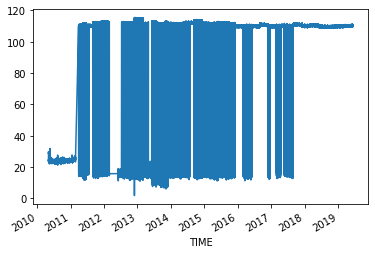

In [18]:
# Plot PRES over TIME
# Because of extra instruments (see NOMINAL_DEPTH vals), there are more pressure vals here compared to WQM
temp_df.PRES.plot()

In [39]:
# Max and min pressure values
bin_max = temp_df.PRES.max()
bin_min = temp_df.PRES.min()
bin_size = 2

In [40]:
def create_bins(bin_size, bin_max):
    """
    A function to return equal sized bins and corresponding bin labels for binning of data.
    Input:
    bin_size: size of bins
    bin_max: maximum value of the data to be binned. The minimum is assumed to be zero.
    """
    num_bins = np.ceil(bin_max/bin_size)
    lab_start = np.ceil(bin_size/2)
    bins = np.linspace(0, bin_size*num_bins, num_bins+1)
    labs = np.linspace(lab_start, bin_size*(num_bins-1)+lab_start, num_bins)
    return bins, labs

In [41]:
# Automatically calculate pressure bin parameters based on given bin_size
bins, labs = create_bins(bin_size, bin_max)

In [42]:
# create a column with pressure bin labels
temp_df['PRES_BIN'] = pd.cut(temp_df.PRES, bins = bins, labels = labs)

In [43]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES','PRES_BIN']).dropna()

In [44]:
temp_df

TEMP
PRES_BIN TIME                          
1.0      2012-11-28 22:00:00  20.759911
3.0      2012-11-28 22:00:00  20.770100
7.0      2013-06-15 07:00:00  19.003767
         2013-06-15 08:00:00  18.982601
         2013-06-15 21:00:00  18.965900
...                                 ...
115.0    2014-11-06 22:00:00  15.896667
         2014-11-07 22:00:00  15.611667
         2014-11-07 23:00:00  15.620000
         2014-11-09 23:00:00  16.000000
         2014-11-10 00:00:00  16.036667

[149829 rows x 1 columns]

In [45]:
temp_df.groupby('PRES_BIN').count()

,TEMP
PRES_BIN,
1.0,1
3.0,1
7.0,189
9.0,3047
11.0,3400
13.0,12072
15.0,33495
17.0,10984
19.0,1395


Based on nominal depths, it looks like most readings are from the 15, 24 and 110 dbar sensors.
So we will create bins around these depths as well.

In [11]:
bins = [0,11,19,20,28,106,114,116]
labs = [5.5,15,19.5,24,(106-28)/2,110,115]

In [12]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'PRES': temp.PRES_REL.values}

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','PRES'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

In [13]:
# create a column with pressure bin labels
temp_df['PRES_BIN'] = pd.cut(temp_df.PRES, bins = bins, labels = labs, include_lowest=True)

In [14]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('PRES_BIN').resample('1D').mean().drop(columns=['PRES']).dropna()

In [15]:
temp_df.groupby('PRES_BIN').count()

,TEMP
PRES_BIN,
5.5,176
15.0,1722
19.5,115
24.0,358
39.0,12
110.0,2802
115.0,105


Based on the binning above, three models will be trained: 15 dbar, 24 dbar and 110 dbar.

### 15 dbar

In [16]:
temp_df_15 = temp_df.xs(15)

In [16]:
temp_df_15

,TEMP
TIME,
2011-03-30,23.995378
2011-03-31,23.710236
2011-04-01,23.333200
2011-04-02,22.781210
2011-04-03,22.811733
...,...
2017-08-23,17.224247
2017-08-24,17.473562
2017-08-25,17.870966


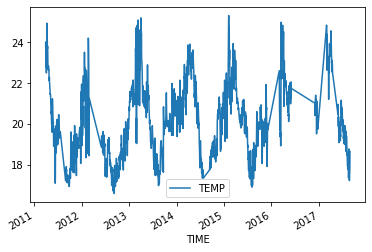

In [17]:
temp_df_15.plot()

In [21]:
Time_diff = temp_df_15.index.to_series().diff()

(array([0.000e+00, 1.685e+03, 1.300e+01, 6.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <a list of 30 Patch objects>)

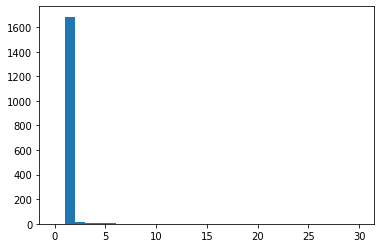

In [24]:
plt.hist(Time_diff/pd.Timedelta(days=1),bins=np.linspace(0,30,31))

(array([0.000e+00, 1.685e+03, 1.300e+01, 6.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        7.000e+00]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30., 185.]),
 <a list of 31 Patch objects>)

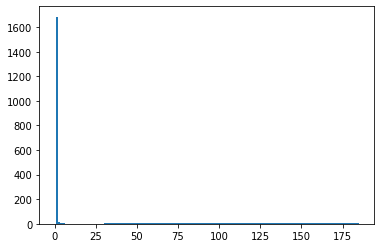

In [19]:
plt.hist((Time_diff/pd.Timedelta(days=1)), bins=np.append(np.linspace(0,30,31),185))#.where((Time_diff/pd.Timedelta(days=1)) > 1))

In [20]:
print('The longest gap in days is '+str((Time_diff/pd.Timedelta(days=1)).max())+' days (approx 6 months)')

The longest gap in days is 182.0 days (approx 6 months)


We will thus use the 6 month period before a gap and a 6 month period after a gap to predict a gap of 6 months using our RNN.

In [21]:
Time_diff.where(Time_diff > pd.Timedelta(days=7)).dropna()

TIME
2011-08-31    41 days
2012-05-31    92 days
2013-09-15    10 days
2014-09-11    46 days
2016-03-01    89 days
2016-11-30   182 days
2017-02-28    68 days
2017-05-26    41 days
Name: TIME, dtype: timedelta64[ns]

In [22]:
Time_diff.where(Time_diff > pd.Timedelta(days=1)).min()

Timedelta('2 days 00:00:00')

If the 6 monthly model is too inaccurate, we can train a (92 day) 3 monthly model which will result in only a single gap of 182 days in the data.

#### Data generator

In [25]:
## find all locations where timeseries has gaps
temp_df_15.iloc[np.where(Time_diff > pd.Timedelta(days=1))[0]]

,TEMP
TIME,
2011-07-13,19.781811
2011-07-15,19.339718
2011-07-20,19.481575
2011-08-31,17.217194
2011-11-16,19.388884
2011-11-21,18.407791
2011-12-01,19.210051
2011-12-05,18.883385
2011-12-07,18.992868


In [22]:
hist_len = 30
targ_len = 1

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1
break_index = np.append(break_index, len(temp_df_15))
window_len = hist_len + targ_len

In [23]:
data = []
labels = []

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1 
window_len = hist_len + targ_len
for w in range(len(break_index)):
    run_start = hist_len if w == 0 else break_index[w-1] + 1 + hist_len
    run_end = break_index[w] - targ_len   
    for i in range(run_start, run_end):
        indices = range(i-hist_len, i)
        data.append(np.reshape(temp_df_15.values[indices], (hist_len,1)))
        labels.append(temp_df_15.values[i+targ_len-1])
        
data = np.array(data)
labels = np.array(labels)

In [24]:
data.shape, labels.shape

((1143, 30, 1), (1143, 1))

In [25]:
# Split into training and test datasets
trainidx = np.random.choice(len(data), int(np.round(0.9*len(data))), replace=False)
train_data = data[trainidx]
train_labels = labels[trainidx]
val_data = np.delete(data, obj=trainidx, axis=0)
val_labels = np.delete(labels, trainidx, axis=0)

In [26]:
# Normalisation
train_mean = train_data.mean()
train_std = train_data.std()

In [27]:
train_data = (train_data-train_mean)/train_std
train_labels = (train_labels-train_mean)/train_std
val_data = (val_data-train_mean)/train_std
val_labels = (val_labels-train_mean)/train_std

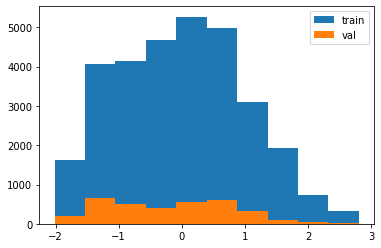

In [28]:
plt.hist(train_data.flatten(), label='train'),plt.hist(val_data.flatten(), label='val')
plt.legend()

#### Model

In [18]:
class descaled_mape(keras.losses.Loss):
    """
    A loss/metric that (de)scales true and predicted values into absolute units before calculating mean absolute percentage error (mape).
    Args:
        mu: mean (usually training data mean)
        sd: standard dev (usually based on training data)
        reduction: Type of tf.keras.losses.Reduction to apply to loss.
        name: name of loss function
    """
    def __init__(self, mu, sd, reduction=keras.losses.Reduction.AUTO, name='descaled_mape'):
        super().__init__(reduction=reduction, name=name)
        self.mu=mu
        self.sd=sd
    
    def call(self, y_true, y_pred):
        y_true = y_true * self.sd + self.mu
        y_pred = y_pred * self.sd + self.mu
        return tf.math.reduce_mean(tf.abs((y_true - y_pred)/y_true))

In [40]:
BATCH_SIZE = 8
BUFFER_SIZE = data.shape[0]

train_univariate = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [59]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=train_data.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics = [descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

In [27]:
simple_lstm_model.load_weights('../data/simple_lstm_daily_hist30_training/cp.ckpt')

In [25]:
bi_lstm_model = tfl.keras.models.Sequential()
bi_lstm_model.add(layers.Bidirectional(layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=train_data.shape[-2:])))
bi_lstm_model.add(layers.Bidirectional(layers.LSTM(16, activation='relu')))
bi_lstm_model.add(layers.Dense(1))

bi_lstm_model.compile(optimizer='adam', loss='mae', metrics=['mse', keras.metrics.MeanAbsolutePercentageError()])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [28]:
bi_lstm_model.load_weights('../data/bi_lstm_training/cp.ckpt')

In [29]:
checkpoint_path = "../data/bi_lstm_training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tfl.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [31]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 10

history = bi_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS,
                 callbacks=[cp_callback])

Epoch 1/10
177/178 [============================>.] - ETA: 1s - loss: 0.0942 - mean_squared_error: 0.0293 - mean_absolute_percentage_error: 74.3006
Epoch 00001: saving model to ../data/bi_lstm_training/cp.ckpt
178/178 [==============================] - 311s 2s/step - loss: 0.0942 - mean_squared_error: 0.0292 - mean_absolute_percentage_error: 104.0024 - val_loss: 0.0952 - val_mean_squared_error: 0.0297 - val_mean_absolute_percentage_error: 61.4463
Epoch 2/10
177/178 [============================>.] - ETA: 1s - loss: 0.0941 - mean_squared_error: 0.0292 - mean_absolute_percentage_error: 76.4515
Epoch 00002: saving model to ../data/bi_lstm_training/cp.ckpt
178/178 [==============================] - 308s 2s/step - loss: 0.0940 - mean_squared_error: 0.0291 - mean_absolute_percentage_error: 76.1902 - val_loss: 0.0979 - val_mean_squared_error: 0.0297 - val_mean_absolute_percentage_error: 62.7333
Epoch 3/10
177/178 [============================>.] - ETA: 1s - loss: 0.0949 - mean_squared_error: 

In [33]:
## Save model
bi_lstm_model.save('../data/saved_models/temp_gapfilling_bi_lstm_model.h5')

In [38]:
## Save History
import pickle
pickle_out = open("../data/bi_lstm_model_history.pickle", "wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

#### Simple LSTM model

In [45]:
print(simple_lstm_model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
checkpoint_path = "../data/simple_lstm_daily_hist30_training_descaled_mape/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')

In [61]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 40

history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS, verbose=0,
                 callbacks=[cp_callback, PrintDot()])

loss:  0.0307, val_loss:  0.0251
..........loss:  0.0179, val_loss:  0.0172
..........loss:  0.0176, val_loss:  0.0173
..........loss:  0.0174, val_loss:  0.0180
..........

In [49]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,descaled_mape,mae,mse,mean_absolute_percentage_error,val_loss,val_descaled_mape,val_mae,val_mse,val_mean_absolute_percentage_error,epoch
0,0.032923,0.032923,0.370482,0.267099,121.678825,0.025108,0.025108,0.283678,0.149409,115.804771,0
1,0.024785,0.024814,0.280219,0.163184,108.004341,0.023417,0.023417,0.261227,0.125484,121.714188,1
2,0.022110,0.022087,0.249788,0.133062,105.537010,0.021764,0.021764,0.240486,0.107757,130.271927,2
3,0.020909,0.020937,0.236931,0.116715,99.426117,0.020530,0.020530,0.225892,0.089451,108.335434,3
4,0.019437,0.019527,0.218813,0.101335,73.510857,0.018497,0.018497,0.205676,0.081282,89.484245,4
5,0.019013,0.019015,0.214253,0.101937,117.052177,0.017896,0.017896,0.200131,0.086861,83.698181,5
6,0.018501,0.018539,0.208538,0.096644,94.958801,0.018900,0.018900,0.210593,0.092155,87.728172,6
7,0.018041,0.018012,0.203514,0.090054,89.535339,0.017171,0.017171,0.191866,0.079864,83.248238,7
8,0.018166,0.018152,0.204667,0.095282,96.265877,0.017199,0.017199,0.191867,0.082219,86.958763,8
9,0.017892,0.017870,0.202038,0.094987,94.886185,0.017554,0.017554,0.196425,0.085905,84.425362,9


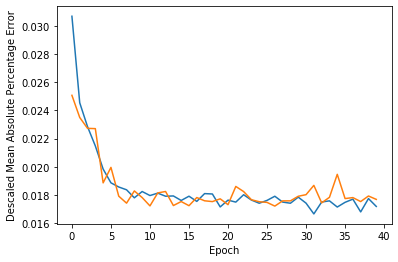

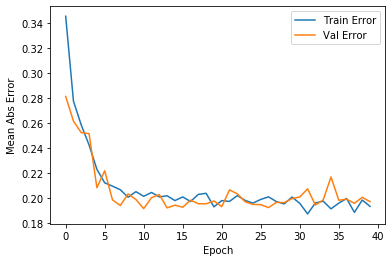

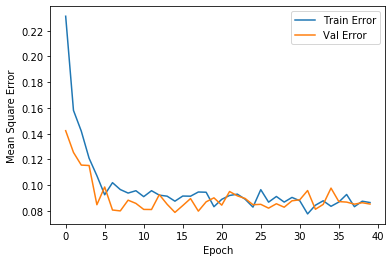

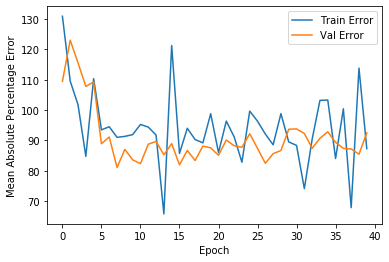

In [62]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Descaled Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['descaled_mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_descaled_mape'],
           label = 'Val Error')
#   plt.ylim([0.9,
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [67]:
## Save model
simple_lstm_model.save('../data/saved_models/temp_gapfilling_daily_simple_lstm_model_hist30_loss-descaledmape.h5')

In [63]:
def create_time_steps(length):
  return list(range(-length, 0))

In [64]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/matplotlib/pyplot.py'>

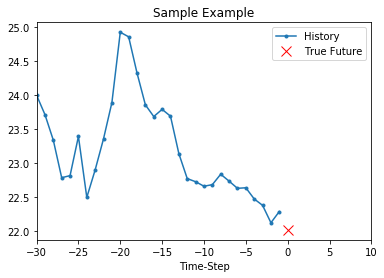

In [30]:
show_plot([data[0], labels[0]], 0, 'Sample Example')

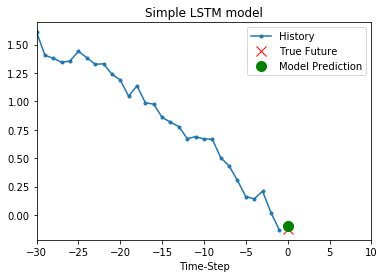

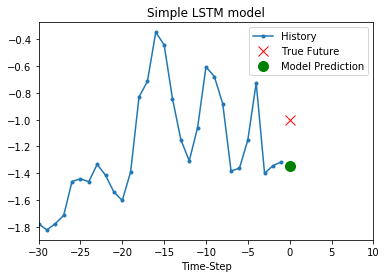

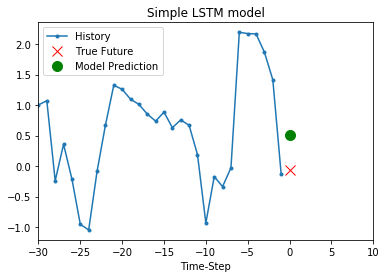

In [65]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

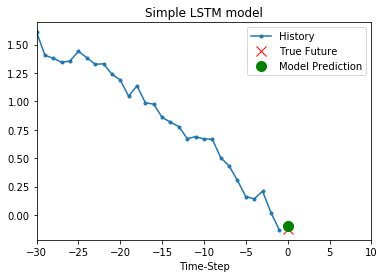

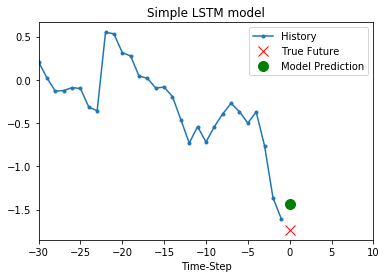

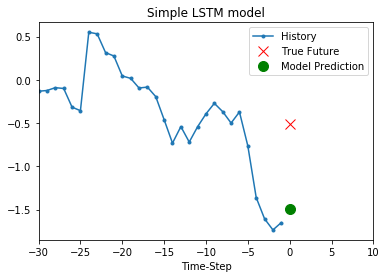

In [66]:
I = 3
x = val_data[:I]
y = val_labels[:I]
for i in range(I):
    plot = show_plot([x[i], y[i],
                      simple_lstm_model.predict(x)[i]], 0, 'Simple LSTM model')
    plot.show()

In [59]:
val_labels[:3]

array([[ 0.784126  ],
       [ 0.220187  ],
       [-0.33998615]], dtype=float32)

In [68]:
y_pred = simple_lstm_model.predict(val_data)

In [36]:
def mape(y, y_hat):
    return np.mean(abs((y-y_hat)/y))

In [37]:
def ape(y, y_hat):
    return abs((y-y_hat)/y) 

In [38]:
def descale(vals, mu, sd):
    return vals*sd+mu

In [72]:
val_labels_descaled = descale(val_labels, train_mean, train_std)
y_pred_descaled = descale(y_pred, train_mean, train_std)

In [73]:
mape(val_labels_descaled, y_pred_descaled)

0.017624924

In [74]:
y_pred_ape = ape(val_labels_descaled, y_pred_descaled)

In [75]:
y_pred_ape[:5]

array([[0.00267899],
       [0.03192249],
       [0.09151462],
       [0.00630937],
       [0.01758764]], dtype=float32)

#### Multi-layer LSTM model with 6 target time steps

In [18]:
hist_len = 30
targ_len = 6

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1
break_index = np.append(break_index, len(temp_df_15))
window_len = hist_len + targ_len

In [19]:
data = []
labels = []

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1 
window_len = hist_len + targ_len
for w in range(len(break_index)):
    run_start = hist_len if w == 0 else break_index[w-1] + 1 + hist_len
    run_end = break_index[w] - targ_len   
    for i in range(run_start, run_end):
        indices = range(i-hist_len, i)
        data.append(np.reshape(temp_df_15.values[indices], (hist_len,1)))
        labels.append(temp_df_15.values[i:i+targ_len])
        
data = np.array(data)
labels = np.array(labels)

In [20]:
data.shape, labels.shape

((1088, 30, 1), (1088, 6, 1))

In [21]:
# Split into training and test datasets
trainidx = np.random.choice(len(data), int(np.round(0.9*len(data))), replace=False)
train_data = data[trainidx]
train_labels = labels[trainidx]
train_labels = train_labels.reshape((len(train_labels),targ_len))
val_data = np.delete(data, obj=trainidx, axis=0)
val_labels = np.delete(labels, trainidx, axis=0)
val_labels = val_labels.reshape((len(val_labels), targ_len))

In [22]:
# Normalisation
train_mean = train_data.mean()
train_std = train_data.std()

In [23]:
train_data = (train_data-train_mean)/train_std
train_labels = (train_labels-train_mean)/train_std
val_data = (val_data-train_mean)/train_std
val_labels = (val_labels-train_mean)/train_std

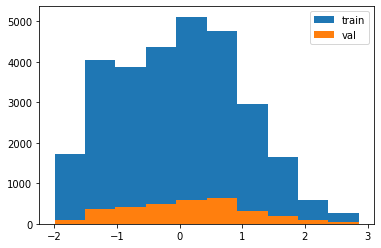

In [24]:
plt.hist(train_data.flatten(), label='train'),plt.hist(val_data.flatten(), label='val')
plt.legend()

In [25]:
BATCH_SIZE = 8
BUFFER_SIZE = data.shape[0]

train_univariate = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [53]:
bilayer_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=train_data.shape[-2:]),
    tf.keras.layers.LSTM(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

bilayer_lstm_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])


In [54]:
checkpoint_path = "../data/bilayer_lstm_daily_hist30_targ6_loss-descaledmape/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')
    
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [59]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 50

history = bilayer_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS, verbose=0,
                 callbacks=[cp_callback, PrintDot()])

loss:  0.0191, val_loss:  0.0189
..........loss:  0.0185, val_loss:  0.0183
..........loss:  0.0186, val_loss:  0.0181
..........loss:  0.0181, val_loss:  0.0176
..........loss:  0.0183, val_loss:  0.0171
..........

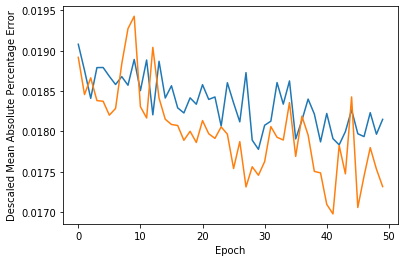

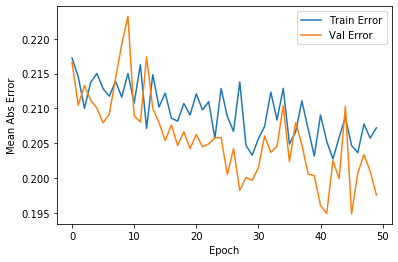

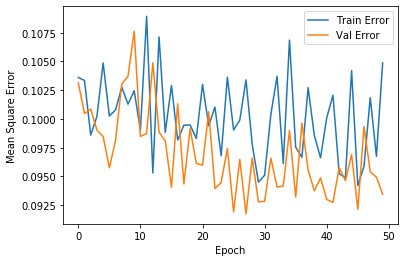

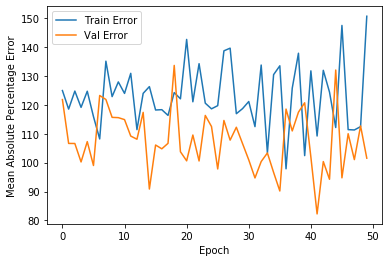

In [60]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Descaled Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['descaled_mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_descaled_mape'],
           label = 'Val Error')
#   plt.ylim([0.9,
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [61]:
## Save model
bilayer_lstm_model.save('../data/saved_models/temp_gapfilling_daily_bilayer_lstm_model_hist30_targ6_loss-descaledmape.h5')

#### Bidirectional multi-layer LSTM with 6 target time steps

In [33]:
#load model if already trained
bidirectional_lstm_model = keras.models.load_model('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist30_targ6_loss-descaledmape.h5')

ValueError: Unknown loss function: descaled_mape

In [49]:
bidirectional_lstm_model = tf.keras.models.Sequential([
    layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=train_data.shape[-2:])),
    layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu')),
    tf.keras.layers.Dense(6)
])

bidirectional_lstm_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])


In [35]:
bidirectional_lstm_model.load_weights('../data/birectional_lstm_daily_hist30_targ6_loss-descaledmape/cp.ckpt')

In [50]:
checkpoint_path = "../data/birectional_lstm_daily_hist30_targ6_loss-descaledmape/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')
    
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [58]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 200

history = bidirectional_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS, verbose=0,
                 callbacks=[cp_callback, PrintDot()])

loss:  0.0417, val_loss:  0.0355
..........loss:  0.0291, val_loss:  0.0266
..........loss:  0.0275, val_loss:  0.0253
..........loss:  0.0265, val_loss:  0.0240
..........loss:  0.0238, val_loss:  0.0242
..........loss:  0.0216, val_loss:  0.0222
..........loss:  0.0195, val_loss:  0.0210
..........loss:  0.0181, val_loss:  0.0195
..........loss:  0.0166, val_loss:  0.0183
..........loss:  0.0160, val_loss:  0.0182
..........loss:  0.0149, val_loss:  0.0176
..........loss:  0.0137, val_loss:  0.0174
..........loss:  0.0129, val_loss:  0.0168
..........loss:  0.0123, val_loss:  0.0161
..........loss:  0.0120, val_loss:  0.0158
..........loss:  0.0112, val_loss:  0.0156
..........loss:  0.0104, val_loss:  0.0145
..........loss:  0.0102, val_loss:  0.0147
..........loss:  0.0098, val_loss:  0.0152
..........loss:  0.0097, val_loss:  0.0144
..........

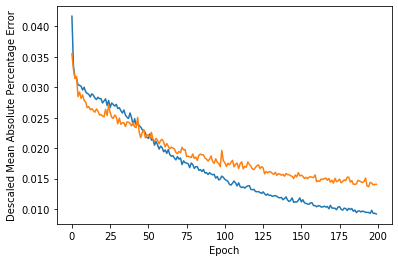

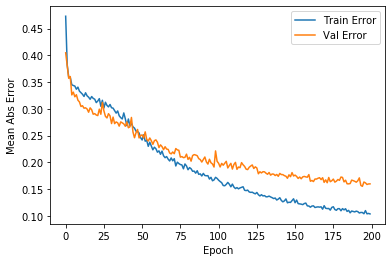

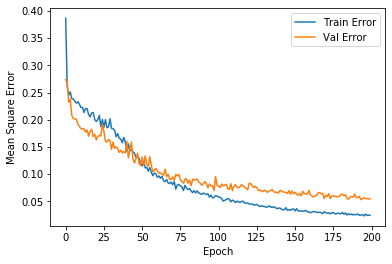

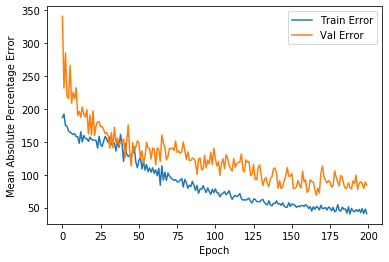

In [59]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Descaled Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['descaled_mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_descaled_mape'],
           label = 'Val Error')
#   plt.ylim([0.9,
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [125]:
## Save model
bidirectional_lstm_model.save('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist30_targ6_loss-descaledmape.h5')

In [61]:
val_data.shape

(109, 30, 1)

In [62]:
y_pred = bidirectional_lstm_model.predict(val_data)

In [63]:
y_pred.shape

(109, 6)

In [66]:
val_labels_descaled = descale(val_labels, train_mean, train_std)
y_pred_descaled = descale(y_pred, train_mean, train_std)

In [67]:
mape(val_labels_descaled, y_pred_descaled)

0.013927746

In [57]:
bidirectional_lstm_model.predict(val_univariate.take(1))

array([[-0.11995208,  0.22474661,  0.01829559,  0.30921084, -0.04557353,
        -0.04537926],
       [-0.08309232,  0.14903313,  0.04602278,  0.2051296 , -0.05441893,
        -0.04167188],
       [-0.05969427,  0.10482225,  0.02721252,  0.12543108, -0.04144   ,
        -0.02768934],
       [-0.02626383,  0.01977495,  0.02163183,  0.03822929, -0.02225745,
        -0.01477582],
       [ 0.01124097, -0.07675366,  0.0876592 , -0.00704336, -0.01458053,
         0.04232878],
       [ 0.01209284, -0.18426321,  0.21678604, -0.00710753, -0.02285334,
         0.08848672],
       [-0.00386942, -0.01970183,  0.02192933, -0.00415766, -0.00249653,
         0.01869244],
       [-0.01728928, -0.01013518,  0.00558929, -0.00426157,  0.00664422,
         0.01116321]], dtype=float32)

In [32]:
def create_time_steps(length):
  return list(range(-length, 0))

In [33]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

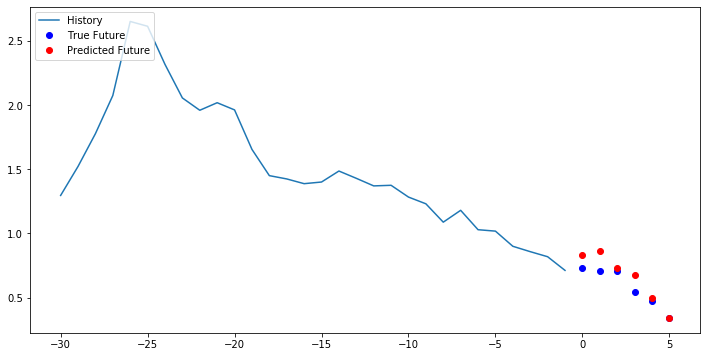

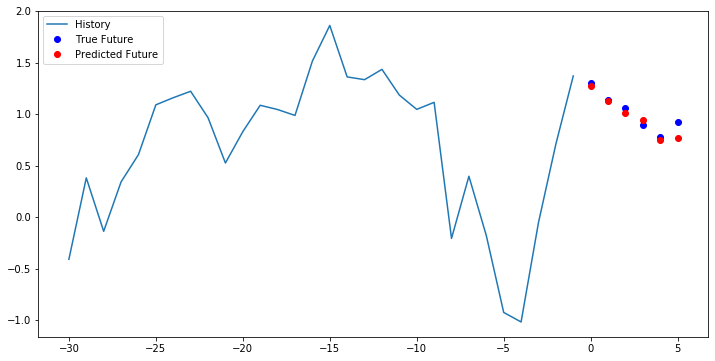

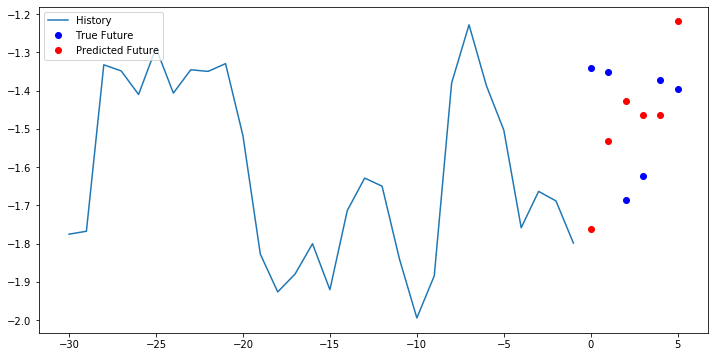

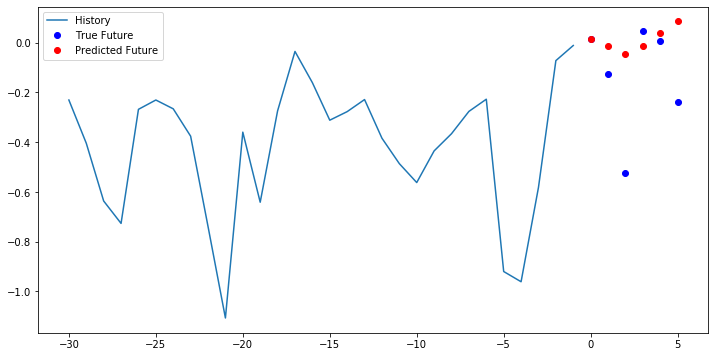

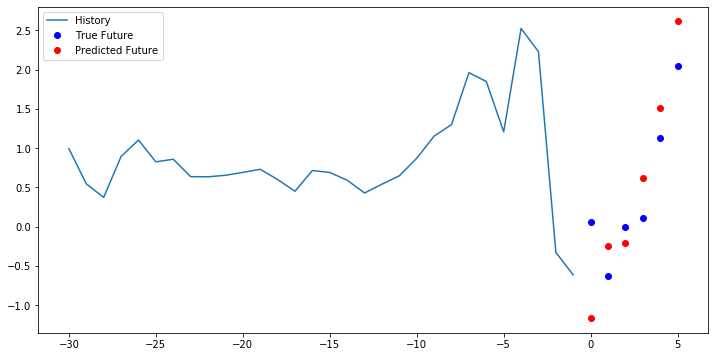

In [108]:
for x, y in val_univariate.take(5):
  multi_step_plot(x[0], y[0], bidirectional_lstm_model.predict(x)[0])

#### Bidirectional tri-layer LSTM model with 10 target time-steps

In [22]:
hist_len = 30
targ_len = 10

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1
break_index = np.append(break_index, len(temp_df_15))
window_len = hist_len + targ_len

In [23]:
data = []
labels = []

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1 
window_len = hist_len + targ_len
for w in range(len(break_index)):
    run_start = hist_len if w == 0 else break_index[w-1] + 1 + hist_len
    run_end = break_index[w] - targ_len   
    for i in range(run_start, run_end):
        indices = range(i-hist_len, i)
        data.append(np.reshape(temp_df_15.values[indices], (hist_len,1)))
        labels.append(temp_df_15.values[i:i+targ_len])
        
data = np.array(data)
labels = np.array(labels)

In [24]:
data.shape, labels.shape

((1044, 30, 1), (1044, 10, 1))

In [25]:
# Split into training and test datasets
trainidx = np.random.choice(len(data), int(np.round(0.9*len(data))), replace=False)
train_data = data[trainidx]
train_labels = labels[trainidx]
train_labels = train_labels.reshape((len(train_labels),targ_len))
val_data = np.delete(data, obj=trainidx, axis=0)
val_labels = np.delete(labels, trainidx, axis=0)
val_labels = val_labels.reshape((len(val_labels), targ_len))

In [26]:
# Normalisation
train_mean = train_data.mean()
train_std = train_data.std()

In [27]:
train_data = (train_data-train_mean)/train_std
train_labels = (train_labels-train_mean)/train_std
val_data = (val_data-train_mean)/train_std
val_labels = (val_labels-train_mean)/train_std

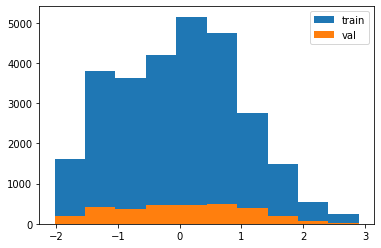

In [28]:
plt.hist(train_data.flatten(), label='train'),plt.hist(val_data.flatten(), label='val')
plt.legend()

In [29]:
BATCH_SIZE = 8
BUFFER_SIZE = data.shape[0]

train_univariate = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [117]:
bidirectional_lstm_targ10_model = tf.keras.models.Sequential([
    layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=train_data.shape[-2:])),
    layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True,)),
    layers.Bidirectional(tf.keras.layers.LSTM(8, activation='relu')),
    tf.keras.layers.Dense(10)
])

bidirectional_lstm_targ10_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])


In [119]:
# check output shape of model
bidirectional_lstm_targ10_model.predict(val_univariate.take(1)).shape

(8, 10)

In [120]:
checkpoint_path = "../data/bidirectional_lstm_daily_hist30_targ10_loss-descaledmape/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')
    
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [121]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 200

history = bidirectional_lstm_targ10_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS, verbose=0,
                 callbacks=[cp_callback, PrintDot()])

loss:  0.0571, val_loss:  0.0387
..........loss:  0.0317, val_loss:  0.0322
..........loss:  0.0306, val_loss:  0.0309
..........loss:  0.0263, val_loss:  0.0277
..........loss:  0.0239, val_loss:  0.0259
..........loss:  0.0236, val_loss:  0.0244
..........loss:  0.0198, val_loss:  0.0213
..........loss:  0.0174, val_loss:  0.0188
..........loss:  0.0166, val_loss:  0.0188
..........loss:  0.0161, val_loss:  0.0178
..........loss:  0.0149, val_loss:  0.0174
..........loss:  0.0145, val_loss:  0.0170
..........loss:  0.0144, val_loss:  0.0171
..........loss:  0.0133, val_loss:  0.0171
..........loss:  0.0129, val_loss:  0.0158
..........loss:  0.0124, val_loss:  0.0158
..........loss:  0.0122, val_loss:  0.0155
..........loss:  0.0116, val_loss:  0.0157
..........loss:  0.0120, val_loss:  0.0148
..........loss:  0.0116, val_loss:  0.0141
..........

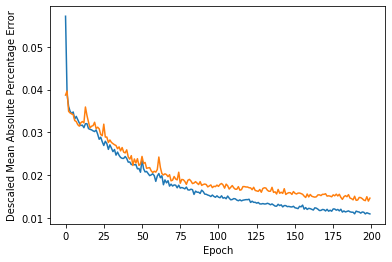

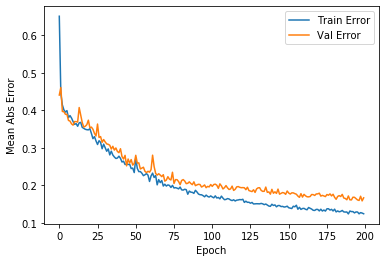

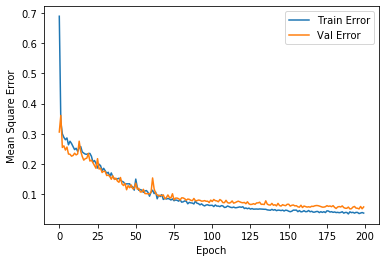

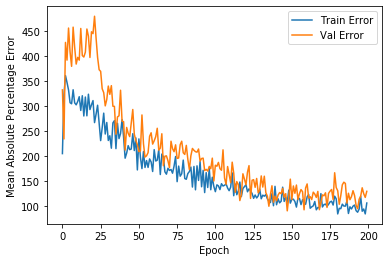

In [122]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Descaled Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['descaled_mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_descaled_mape'],
           label = 'Val Error')
#   plt.ylim([0.9,
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [124]:
## Save model
bidirectional_lstm_targ10_model.save('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist30_targ10_loss-descaledmape.h5')

In [30]:
#load model if already trained
bidirectional_lstm_targ10_model = keras.models.load_model('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist30_targ10_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ10_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

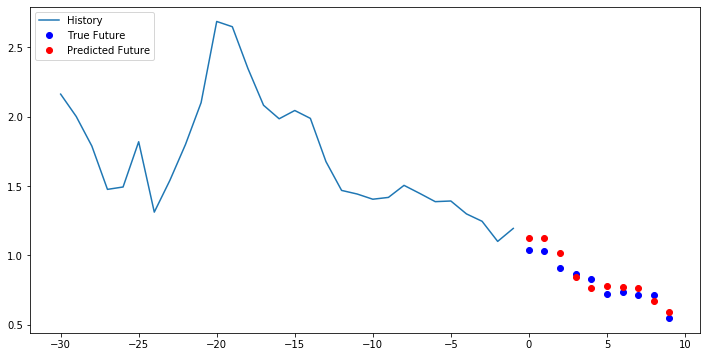

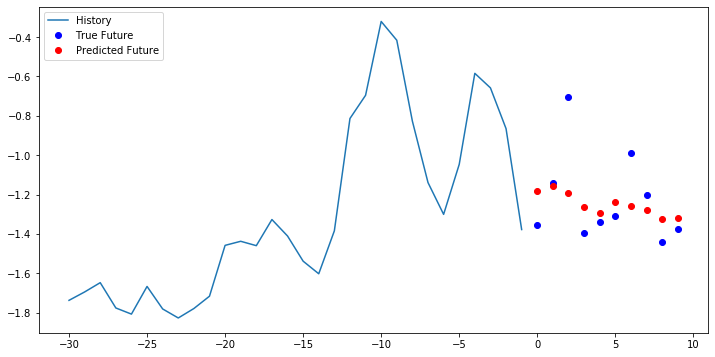

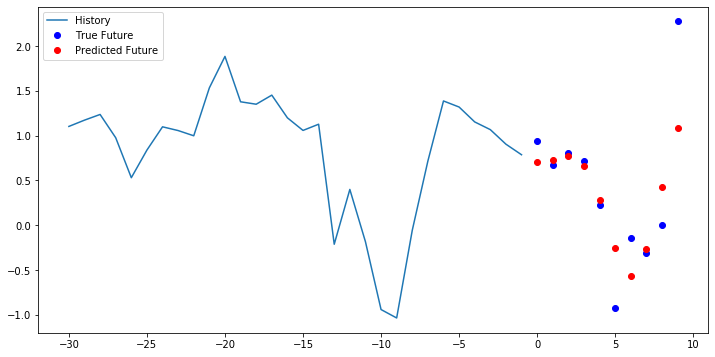

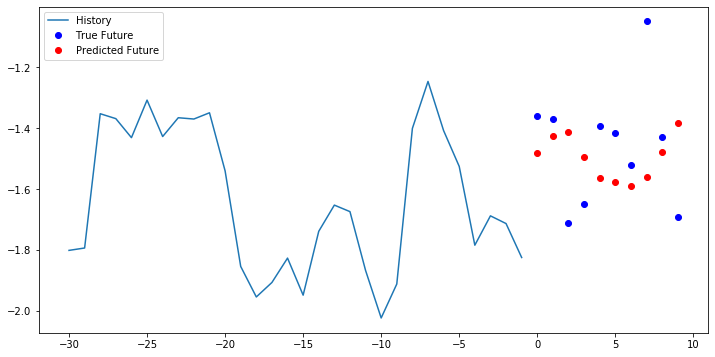

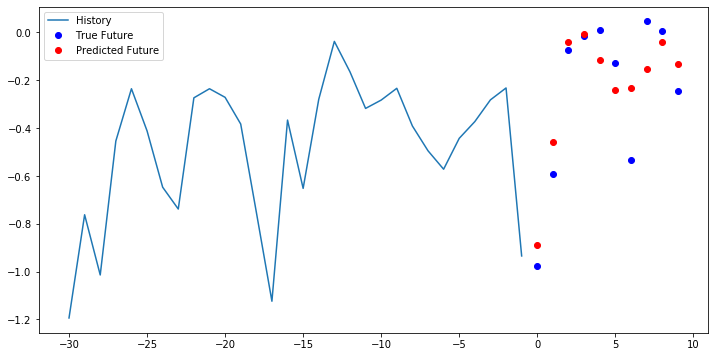

In [34]:
for x, y in val_univariate.take(5):
  multi_step_plot(x[0], y[0], bidirectional_lstm_targ10_model.predict(x)[0])

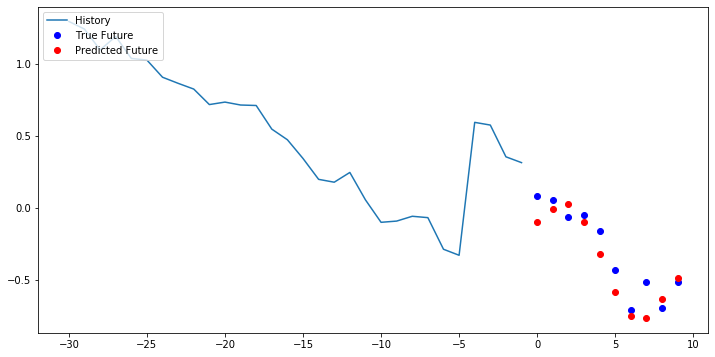

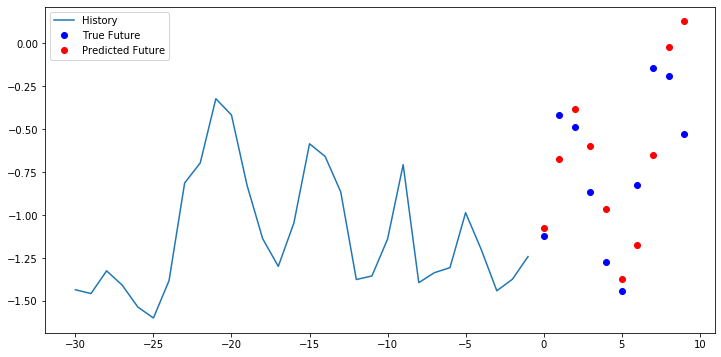

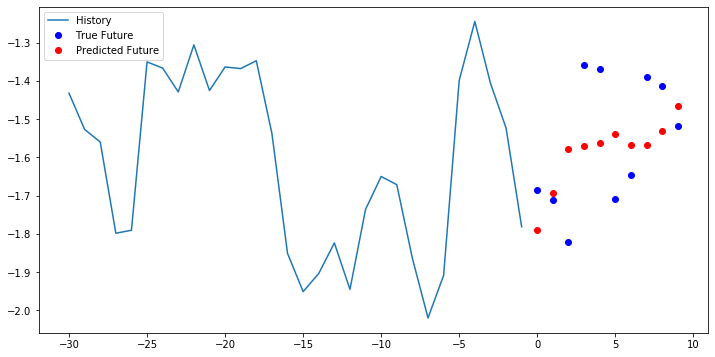

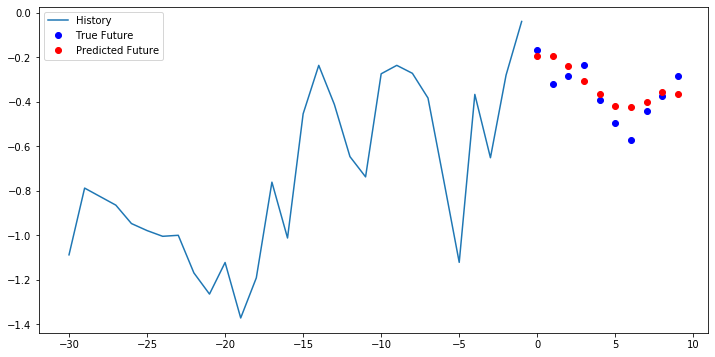

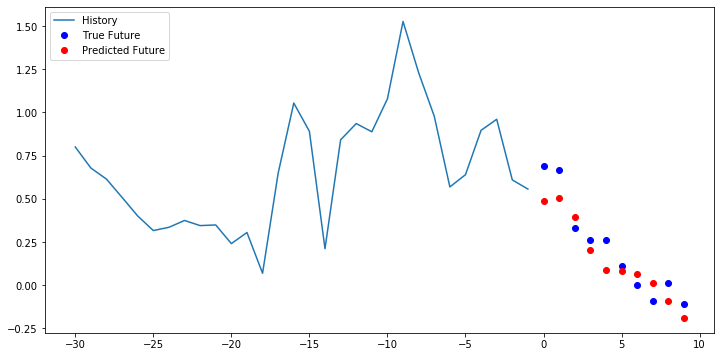

In [131]:
for x, y in val_univariate.take(5):
  multi_step_plot(x[0], y[0], bidirectional_lstm_targ10_model.predict(x)[0])

### Compare with interpolation

In [62]:
temp_df_15 = temp_df.xs(15)

In [138]:
np.where(Time_diff/pd.Timedelta(days=1) == 10)

(array([736]),)

In [145]:
Time_diff[670:740]

TIME
2013-06-25    1 days
2013-06-26    1 days
2013-06-27    1 days
2013-06-28    1 days
2013-06-29    1 days
               ...  
2013-09-05    5 days
2013-09-15   10 days
2013-09-16    1 days
2013-09-17    1 days
2013-09-18    1 days
Name: TIME, Length: 70, dtype: timedelta64[ns]

In [147]:
len(Time_diff) == len(temp_df_15)

True

In [63]:
temp_df_15 = temp_df_15.asfreq(freq='1D')

In [64]:
# Use interpolateTime to fill nans
temp_df_15 = temp_df_15.assign(InterpTime = temp_df_15.TEMP.interpolate(method='time'))

In [65]:
# create a sampele_df that subsets to a small period with a few gaps of different lengths
sample_df = temp_df_15.loc['2013-06-25':'2013-09-18']

In [66]:
# get the temp values with nans to be filled by the LSTM model
sample = temp_df_15.loc['2013-06-25':'2013-09-18'].TEMP.values

In [67]:
def gapfill(sample, lstm_model, train_mean, train_std):
    """
    Function to fill gaps in a timeseries with a LSTM RNN model
    Args:
        sample: A numpy array of timeseries with gaps represented by NaNs
        lstm_model: A model trained on the entire sample dataset for gap-filling
        train_mean: the mean value to de(re)scale model output with
        train_std: sd to de(re)scale model output with
    """
    
    while np.any(np.isnan(sample)):
        # find the first NaN
        gap_start = np.min(np.argwhere(np.isnan(sample))) 
        if gap_start < 30:
            print('Error: There must be atleast 30 non nan values before the first gap for the prediction to work.')
            break
        else:
            # find gap length
            gap_length = np.min(np.argwhere(~np.isnan(sample[gap_start:]))) 
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(sample[:gap_start][-30:], (1,30,1))
            # scale history
            history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = bidirectional_lstm_targ10_model.predict(history)[0,:gap_length]
            out = out * train_std + train_mean
            sample[gap_start : gap_start + gap_length] = out
        
    return sample

In [68]:
sample_df['LSTM_prediction'] = gapfill(sample, bidirectional_lstm_targ10_model, train_mean, train_std) 

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
sample_df

,TEMP,InterpTime,LSTM_prediction
TIME,,,
2013-06-25,19.120962,19.120962,19.120962
2013-06-26,19.272366,19.272366,19.272366
2013-06-27,19.720718,19.720718,19.720718
2013-06-28,19.910772,19.910772,19.910772
2013-06-29,19.659788,19.659788,19.659788
...,...,...,...
2013-09-14,NaN,17.845295,17.924938
2013-09-15,17.697260,17.697260,17.697260
2013-09-16,18.169317,18.169317,18.169317


In [70]:
# remove predictions where there are no nans
sample_df.InterpTime.iloc[np.where(~np.isnan(sample_df.TEMP))] = np.nan
sample_df.LSTM_prediction.iloc[np.where(~np.isnan(sample_df.TEMP))] = np.nan

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
def gapfilling_comp_plot(plot_df):
  plt.figure(figsize=(12, 6))

  plt.plot(plot_df.index, plot_df.TEMP, label='Gappy timeseries')
  plt.plot(plot_df.index, plot_df.InterpTime, 'bo',
           label='Interpolated')
  plt.plot(plot_df.index, plot_df.LSTM_prediction, 'ro',
            label='LSTM predicted')
  plt.legend(loc='upper left')
  plt.show()

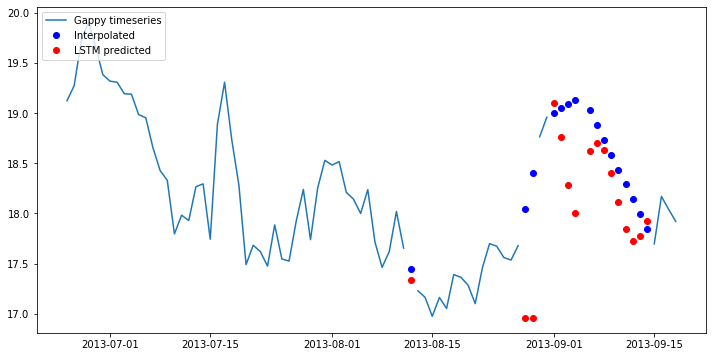

In [72]:
gapfilling_comp_plot(sample_df)